# Objective: Compare Model Simulations with Experimental Data

In [1]:
import cobra
from cobra import Model, Reaction, Metabolite

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# In this workshop We will use an unpublished version of the <i>C. diff</i> 630 model (iCN900). Please don't distribute!

In [2]:
CDmod=cobra.io.load_json_model('iCN900_09062018.json')

In [179]:
def set_min_media(model):
    # set all exchange reactions to lower bound of 0: e.g. nothing can enter the cell
    ex_rxns = [r for r in model.reactions if r.id.startswith('EX')]
    for r in ex_rxns:
        r.lower_bound = 0
        
    #define our minimal media exchanges:
    min_media = {
        'EX_glc__D_e':-10,
        'EX_leu__L_e':-1,
        'EX_k_e': -1000,
        'EX_pydxn_e': -1,
        'EX_fe2_e': -1000,
        'EX_cobalt2_e': -1000,
        'EX_ca2_e': -1000,
        'EX_ile__L_e': -1,
        'EX_mg2_e': -1000,
        'EX_pro__L_e': -1,
        'EX_pi_e': -1000,
        'EX_trp__L_e': -1,
        'EX_met__L_e': -1,
        'EX_cys__L_e': -1,
        'EX_btn_e': -1,
        'EX_pnto__R_e': -1,
        'EX_na1_e': -1000,
        'EX_zn2_e': -1000,
        'EX_h_e': -1000,
        'EX_co2_e': -1000,
        'EX_val__L_e': -1,
        'EX_h2o_e': -1000,
        'EX_sel_e': -1000,
        'EX_slnt_e': -1000
    }
    for r in min_media.keys():
        rxn = model.reactions.get_by_id(r)
        rxn.lower_bound = min_media[r]
    return model

In [181]:
CDmod=set_min_media(CDmod) #set to minimal media
CDmod.reactions.EX_glc__D_e.lower_bound=0 #close glucose exchange
CDmod.optimize().f #ensure no growth since currently no carbon source

0.0

# Data used in this workshop is a subset of data generated by the Baylor group

In [4]:
#Load the data to be used for this workshop
Data=pd.read_csv('WorkshopData.csv')
Data

,Compound,BiGG Exchange Reaction,Biolog Data
0,Fructose,EX_fru_e,3.733333
1,Mannose,EX_man_e,3.700000
2,Glucose,EX_Glc_aD_e,3.866667
3,Sorbitol,EX_sbt__D_e,3.266667
4,N-Acetyl-D-Glucosamine,EX_acgam_e,3.566667
5,Glycerol,EX_glyc_e,0.966667
6,Galactose,EX_gal_bD_e,0.966667
7,Salicin,EX_salcn_e,3.085000
8,N-Acetyl-D-Mannosamine,EX_acmana_e,1.866667
9,Maltotriose,EX_malttr_e,0.900000


## 1. Obtain Model Predictions for Each Compound in Data

In [5]:
#Get a list of exchange reactions from the loaded data
listCompounds=list(Data['BiGG Exchange Reaction'])

In [6]:
####Solution

GrowthRates=[]

for c in listCompounds:
    CDmod.reactions.get_by_id(c).lower_bound=-10
    GrowthRates.append(CDmod.optimize().f)
    CDmod.reactions.get_by_id(c).lower_bound=0

In [7]:
Data['Model Predictions'] = pd.Series(GrowthRates, index=Data.index)
Data

,Compound,BiGG Exchange Reaction,Biolog Data,Model Predictions
0,Fructose,EX_fru_e,3.733333,0.014599
1,Mannose,EX_man_e,3.700000,0.014599
2,Glucose,EX_Glc_aD_e,3.866667,0.014599
3,Sorbitol,EX_sbt__D_e,3.266667,0.014599
4,N-Acetyl-D-Glucosamine,EX_acgam_e,3.566667,0.022989
5,Glycerol,EX_glyc_e,0.966667,0.014599
6,Galactose,EX_gal_bD_e,0.966667,0.014599
7,Salicin,EX_salcn_e,3.085000,0.000000
8,N-Acetyl-D-Mannosamine,EX_acmana_e,1.866667,0.000000
9,Maltotriose,EX_malttr_e,0.900000,0.000000


## 2. Apply Thresholds to Experimental Data and Model Predictions

### First Implement the Threshold and Assign 'Growth' or 'No Growth' Conditions

In [8]:
#Apply Thresholds to both Biolog Data and Model Predictions
binarizedData=Data.copy()

#Consider Biolog Data Values of Greater than 1.1 to be Growth
binarizedData.loc[Data['Biolog Data']<=1.1,'Biolog Data']='No Growth'
binarizedData.loc[Data['Biolog Data']>1.1,'Biolog Data']='Growth'

#Consider Model Predicted Growth Values of Greater than 0 to be Growth
binarizedData.loc[Data['Model Predictions']==0,'Model Predictions']='No Growth'
binarizedData.loc[Data['Model Predictions']>0,'Model Predictions']='Growth'

binarizedData

,Compound,BiGG Exchange Reaction,Biolog Data,Model Predictions
0,Fructose,EX_fru_e,Growth,Growth
1,Mannose,EX_man_e,Growth,Growth
2,Glucose,EX_Glc_aD_e,Growth,Growth
3,Sorbitol,EX_sbt__D_e,Growth,Growth
4,N-Acetyl-D-Glucosamine,EX_acgam_e,Growth,Growth
5,Glycerol,EX_glyc_e,No Growth,Growth
6,Galactose,EX_gal_bD_e,No Growth,Growth
7,Salicin,EX_salcn_e,Growth,No Growth
8,N-Acetyl-D-Mannosamine,EX_acmana_e,Growth,No Growth
9,Maltotriose,EX_malttr_e,No Growth,No Growth


### Same Thresholds But Assign Unique Integer Values to Each Case for Visualization

In [9]:
binarizedData=Data.copy()

#Biolog Data
binarizedData.loc[Data['Biolog Data']<=1.1,'Biolog Data']=-2 #No Growth
binarizedData.loc[Data['Biolog Data']>1.1,'Biolog Data']=0 #Growth

#Model Predictions
binarizedData.loc[Data['Model Predictions']==0,'Model Predictions']=1 #No Growth
binarizedData.loc[Data['Model Predictions']>0,'Model Predictions']=2 #Growth

#Create an additional column that is the sum of the experimental data and model predictions
binarizedData['Sums'] = pd.Series(binarizedData['Biolog Data']+binarizedData['Model Predictions'], index=binarizedData.index)

In [10]:
#Now the "Sums" column contains all the types of prediction agreement as follows:

# 2 = True Positive
# 0 = False Positive
# 1 = False Negative
# -1 = True Negative

binarizedData

,Compound,BiGG Exchange Reaction,Biolog Data,Model Predictions,Sums
0,Fructose,EX_fru_e,0.0,2.0,2.0
1,Mannose,EX_man_e,0.0,2.0,2.0
2,Glucose,EX_Glc_aD_e,0.0,2.0,2.0
3,Sorbitol,EX_sbt__D_e,0.0,2.0,2.0
4,N-Acetyl-D-Glucosamine,EX_acgam_e,0.0,2.0,2.0
5,Glycerol,EX_glyc_e,-2.0,2.0,0.0
6,Galactose,EX_gal_bD_e,-2.0,2.0,0.0
7,Salicin,EX_salcn_e,0.0,1.0,1.0
8,N-Acetyl-D-Mannosamine,EX_acmana_e,0.0,1.0,1.0
9,Maltotriose,EX_malttr_e,-2.0,1.0,-1.0


In [11]:
#Create a new dataframe that is just the sums to visualize
toplot=binarizedData[['Compound','Sums']]
toplot=toplot.set_index('Compound')
toplot

,Sums
Compound,
Fructose,2.0
Mannose,2.0
Glucose,2.0
Sorbitol,2.0
N-Acetyl-D-Glucosamine,2.0
Glycerol,0.0
Galactose,0.0
Salicin,1.0
N-Acetyl-D-Mannosamine,1.0


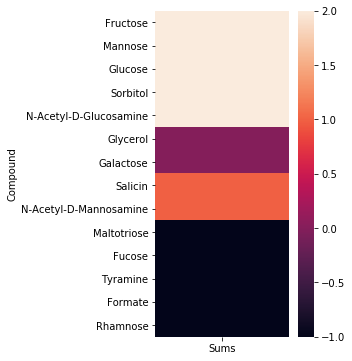

In [12]:
#By assigning the integers, we can easily visualize the agreement between experimental data and model predictions
fig,ax=plt.subplots(figsize=(3,6))
sns_plot=sns.heatmap(toplot, ax=ax)

## 3. Fixing False Negative Model Predictions

In [13]:
#From the above analysis we can see that N-acetyl-D-Mannosamine and Salicin are False Negatives
# i.e.the experimental data suggests the organism can grow on these compounds, but the model doesn't recapitulate this 

## Looking at N-acetyl -D-Mannosamine:

In [14]:
#look at which reactions contain acmana_e
CDmod.metabolites.acmana_e.reactions

frozenset({<Reaction EX_acmana_e at 0x113a05f8>})

In [15]:
#Notice that the above set does not contain a transport reaction, add a transport reaction for acmana:

In [16]:
#Solution

ACNAMt = Reaction('ACNAMt')
ACNAMt.name = 'ACNAM transport'
ACNAMt.add_metabolites({CDmod.metabolites.acmana_e:-1,
                     CDmod.metabolites.acmana_c:1,})
CDmod.add_reactions([ACNAMt])

In [17]:
#See if Adding the transport reaction allows the model to grow utilizing this compound
CDmod.reactions.EX_acmana_e.lower_bound=-10
CDmod.optimize().f

0.02298850574712626

In [18]:
#Adding the transporter alone makes the model agree with the experimental data

In [19]:
#Remove acmana_e from the in silico media for the next part
CDmod.reactions.EX_acmana_e.lower_bound=0

## Now try to remedy the Salicin False Negative:

In [20]:
#Hint: use the BiGG database to find a model that include Salicin and see potentially useful pathways
#Remember using ESCHER to visualize those pathways is always a helpful tool during curation

In [21]:
#SOLUTION
uni=cobra.io.load_json_model('universal.json')

In [22]:
CDmod.add_reactions([uni.reactions.SALCpts,uni.reactions.S6PG,
                     uni.reactions.get_by_id("2HXMPt6"),uni.reactions.EX_2hxmp_e])

CDmod.reactions.get_by_id("2HXMPt6").lower_bound=-1000

CDmod.reactions.EX_salcn_e.lower_bound=-10
CDmod.optimize().f

#Notice that while this enables the usage of salicin as a carbon source it will require the efflux of 2hxmp_e if
#the sole source. This is something that could be tested for accuracy back in the wetlab

0.014598540145985404